In [1]:
# Post-processing with conformal prediction, using the logits tracked from training
import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# analyze the dataframes for training and validation from each epoch
# we start by grabbing the dataframes

#csv_folder = "../logs/Baseline_r2plus1d_all/csvs/"
csv_folder = "../logs/R18_tmed/round2/csvs"
train_csvs = glob.glob(f"{csv_folder}/train_*.csv")
val_csvs = glob.glob(f"{csv_folder}/val_*.csv")

N_CLASSES=3
ALPHA=0.90

def extract_file_index(filename):
    # Use regular expression to find numerical part in the filename
    match = re.findall(r'\d+', filename)[-3]
    if match:
        numerical_part = int(match)
        return numerical_part
    else:
        # Return a default value or handle the case where no numerical part is found
        return None

# sort ascending by the numerical suffix for each file with regex search
def sort_by_epoch(files_list):
    indices = []
    for i in range(len(files_list)):
        index = extract_file_index(files_list[i])
        indices.append(index)
    new_array = [None] * len(indices)
    for j in range(len(indices)):
        new_array[indices[j]] = files_list[j]
    return new_array

print(sort_by_epoch(val_csvs))
#print(train_csvs)

['../logs/R18_tmed/round2/csvs/val_0_0.42.csv', '../logs/R18_tmed/round2/csvs/val_1_0.53.csv', '../logs/R18_tmed/round2/csvs/val_2_0.51.csv', '../logs/R18_tmed/round2/csvs/val_3_0.56.csv', '../logs/R18_tmed/round2/csvs/val_4_0.53.csv', '../logs/R18_tmed/round2/csvs/val_5_0.56.csv', '../logs/R18_tmed/round2/csvs/val_6_0.57.csv', '../logs/R18_tmed/round2/csvs/val_7_0.55.csv', '../logs/R18_tmed/round2/csvs/val_8_0.57.csv', '../logs/R18_tmed/round2/csvs/val_9_0.58.csv', '../logs/R18_tmed/round2/csvs/val_10_0.58.csv', '../logs/R18_tmed/round2/csvs/val_11_0.58.csv', '../logs/R18_tmed/round2/csvs/val_12_0.59.csv', '../logs/R18_tmed/round2/csvs/val_13_0.58.csv', '../logs/R18_tmed/round2/csvs/val_14_0.57.csv', '../logs/R18_tmed/round2/csvs/val_15_0.60.csv', '../logs/R18_tmed/round2/csvs/val_16_0.56.csv', '../logs/R18_tmed/round2/csvs/val_17_0.58.csv', '../logs/R18_tmed/round2/csvs/val_18_0.58.csv', '../logs/R18_tmed/round2/csvs/val_19_0.59.csv', '../logs/R18_tmed/round2/csvs/val_20_0.54.csv', '

In [3]:
train_df = [pd.read_csv(x) for x in sort_by_epoch(train_csvs)]
val_df = [pd.read_csv(x) for x in sort_by_epoch(val_csvs)]

# since train_df is ordered randomly, sort each dataframe by the filename
train_df = [df.sort_values(by=['filename']).reset_index() for df in train_df]
val_df = [df.sort_values(by=['filename']).reset_index() for df in val_df]

In [4]:
train_df[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2
0,3085,3085,/data/TMED/approved_users_only/view_and_diagno...,1,-1.247170,-0.600199,0.393917
1,3096,3096,/data/TMED/approved_users_only/view_and_diagno...,1,-1.088352,-0.638580,0.855858
2,515,515,/data/TMED/approved_users_only/view_and_diagno...,1,0.200256,0.241111,-0.593987
3,774,774,/data/TMED/approved_users_only/view_and_diagno...,1,0.380645,0.204811,-0.489134
4,3531,3531,/data/TMED/approved_users_only/view_and_diagno...,1,-0.428689,-0.766572,-0.362698
...,...,...,...,...,...,...,...
3841,784,784,/data/TMED/approved_users_only/view_and_diagno...,1,0.403851,-0.327671,1.115955
3842,944,944,/data/TMED/approved_users_only/view_and_diagno...,1,0.091985,-0.884138,0.699592
3843,3330,3330,/data/TMED/approved_users_only/view_and_diagno...,1,-0.655585,-1.534020,1.890198
3844,3456,3456,/data/TMED/approved_users_only/view_and_diagno...,1,-0.744171,-1.205880,1.167412


In [5]:
def df_to_logits(df, sm=False):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    if sm:
        logits = softmax(logits, axis=1)
    return logits

train_probs = [df_to_logits(x, False) for x in train_df]
val_probs = [df_to_logits(x, False) for x in val_df]

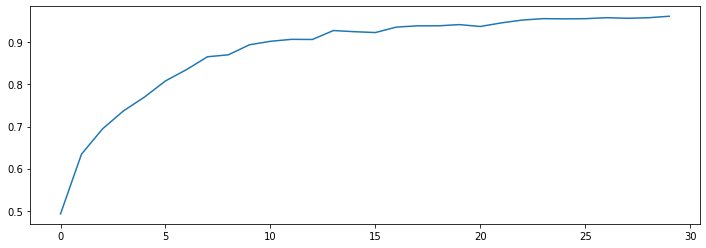

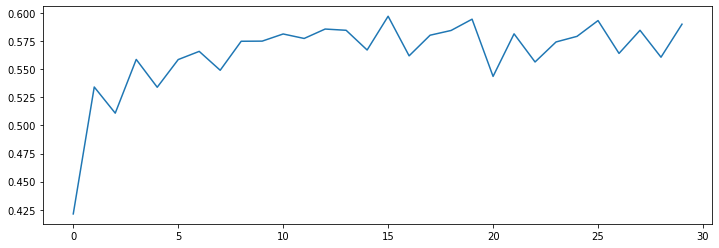

[[ 301   75  404]
 [  98  173  351]
 [ 302  215 1927]]
[[ 430   40  310]
 [  59  195  368]
 [ 101   52 2291]]
[[ 533   26  221]
 [  59  216  347]
 [  75   45 2324]]
[[ 551   29  200]
 [  39  268  315]
 [  49   53 2342]]
[[ 600   19  161]
 [  38  294  290]
 [  52   47 2345]]
[[ 622   18  140]
 [  38  334  250]
 [  27   33 2384]]
[[ 644    9  127]
 [  35  369  218]
 [  26   31 2387]]
[[ 663    8  109]
 [  31  410  181]
 [  23   17 2404]]
[[ 673   11   96]
 [  16  412  194]
 [  26   17 2401]]
[[ 698    6   76]
 [  26  444  152]
 [  11   21 2412]]
[[ 709    6   65]
 [  23  445  154]
 [  10    9 2425]]
[[ 708    7   65]
 [  25  462  135]
 [   9   15 2420]]
[[ 706    7   67]
 [  20  461  141]
 [  15   10 2419]]
[[ 733    7   40]
 [  16  486  120]
 [   7    9 2428]]
[[ 719    5   56]
 [  14  487  121]
 [   6    9 2429]]
[[ 709    2   69]
 [  11  490  121]
 [   7   12 2425]]
[[ 723    3   54]
 [  10  505  107]
 [   6    4 2434]]
[[ 733    1   46]
 [  14  508  100]
 [   3    9 2432]]
[[ 733    

In [6]:
# show the trend-line of prediction F1 score for training and test set
def plot_f1_over_time(epoch_0_dataframe, all_probs):
    # epoch_0_dataframe is the dataframe results at epoch 0
    # probs_progression is the list of probabilities for each epoch
    gt = np.array(epoch_0_dataframe['y'])
    preds = [np.argmax(p, axis=1) for p in all_probs]
    f1s = [f1_score(gt, p, average='macro') for p in preds]
    fig, ax = plt.subplots(figsize=(12,4))
    t = np.arange(len(preds))
    ax.plot(t, f1s)
    plt.show()

def cf_over_time(epoch_0_dataframe, all_probs):
    gt = np.array(epoch_0_dataframe['y'])
    preds = [np.argmax(p, axis=1) for p in all_probs]
    [print(confusion_matrix(gt, p)) for p in preds]

plot_f1_over_time(train_df[0], train_probs)
plot_f1_over_time(val_df[0], val_probs)
cf_over_time(train_df[0], train_probs)
cf_over_time(val_df[0], val_probs)

Epoch 0, F1 score = 0.4212620277688847


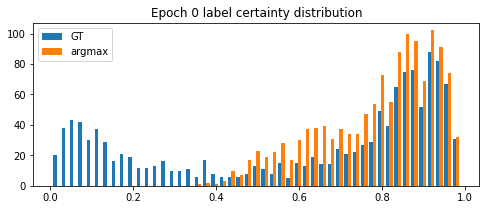

Epoch 1, F1 score = 0.5342491693827639


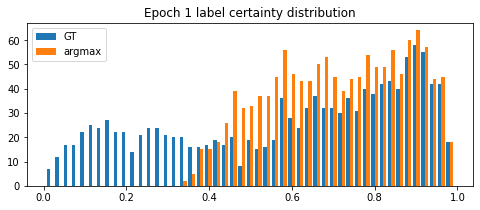

Epoch 2, F1 score = 0.5109600978655635


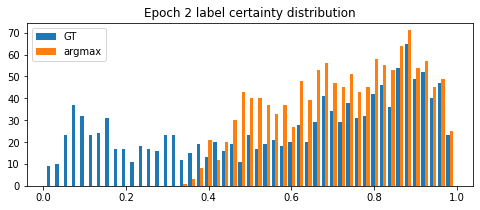

Epoch 3, F1 score = 0.5587958137988753


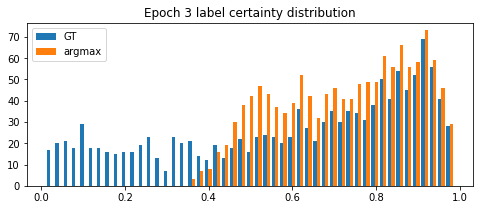

Epoch 4, F1 score = 0.5340296782783297


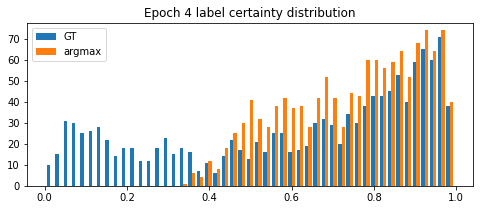

Epoch 5, F1 score = 0.5586765222632347


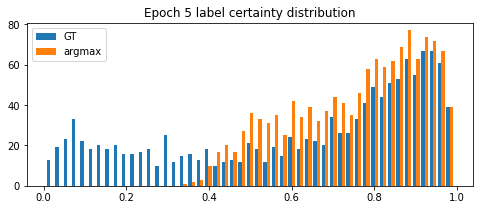

Epoch 6, F1 score = 0.5659639725614719


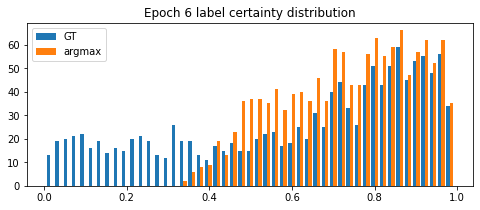

Epoch 7, F1 score = 0.5491498073131456


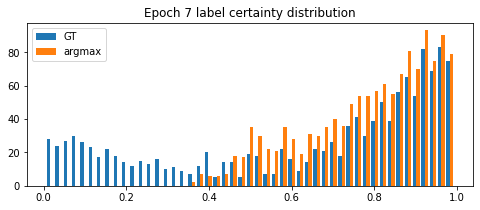

Epoch 8, F1 score = 0.5749689648201274


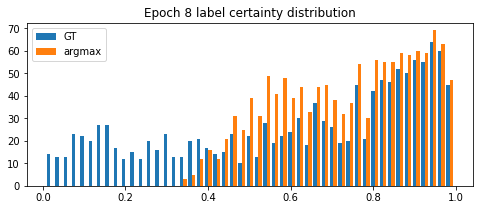

Epoch 9, F1 score = 0.5750864208811123


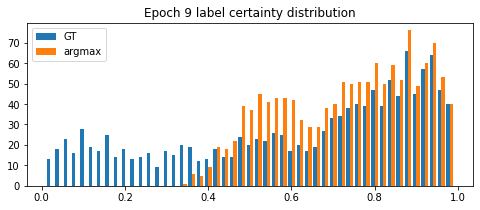

Epoch 10, F1 score = 0.5814568784684254


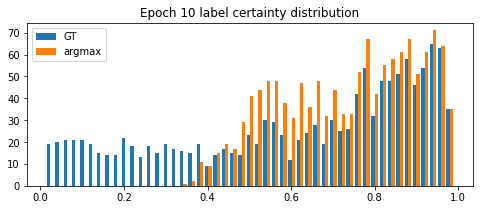

Epoch 11, F1 score = 0.5774629230328189


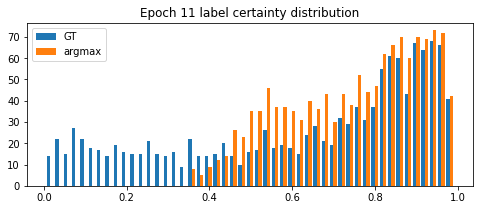

Epoch 12, F1 score = 0.5858423250984499


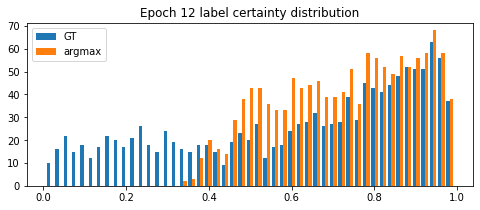

Epoch 13, F1 score = 0.5847394727638378


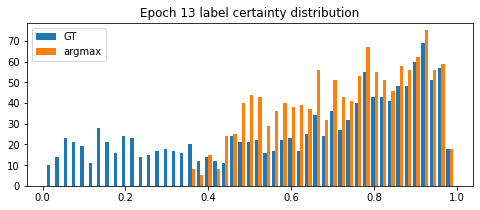

Epoch 14, F1 score = 0.5671882024063858


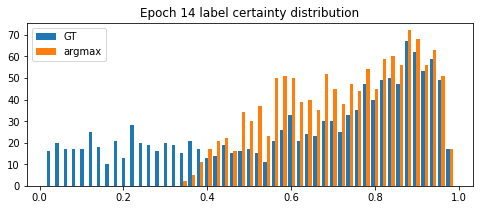

Epoch 15, F1 score = 0.5972420117395995


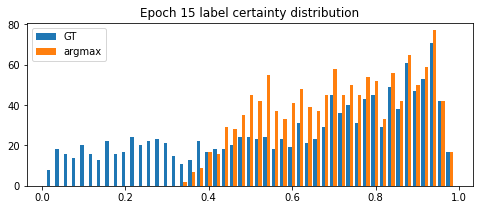

Epoch 16, F1 score = 0.5619923707817875


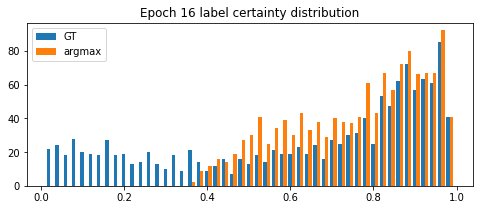

Epoch 17, F1 score = 0.5803589125604721


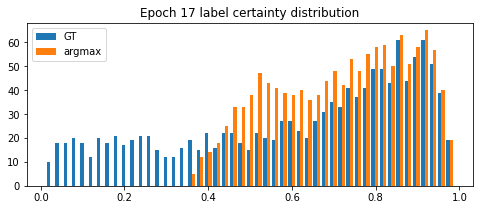

Epoch 18, F1 score = 0.5845840940593868


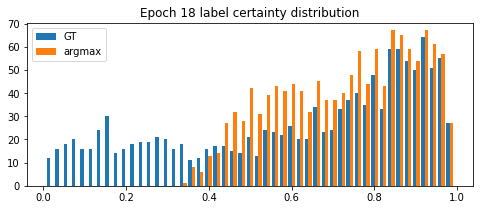

Epoch 19, F1 score = 0.5946241199230161


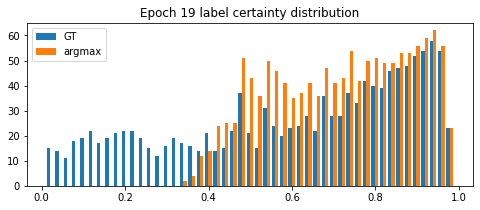

Epoch 20, F1 score = 0.5436933349101426


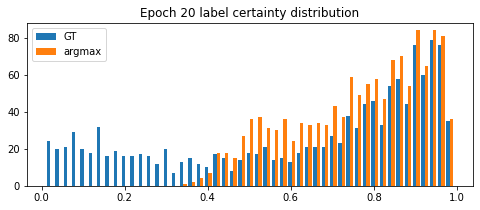

Epoch 21, F1 score = 0.5815772089344322


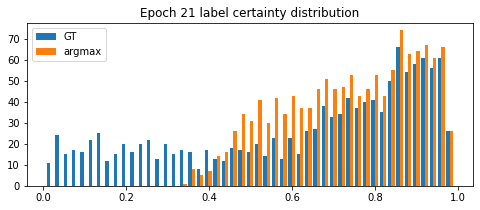

Epoch 22, F1 score = 0.5565322484090599


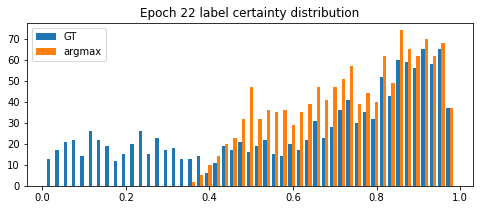

Epoch 23, F1 score = 0.5743524313961071


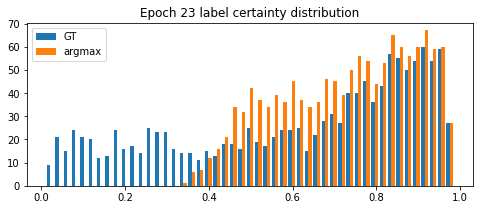

Epoch 24, F1 score = 0.5793462718143852


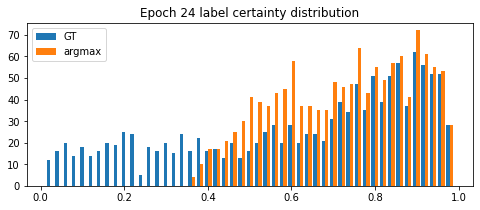

Epoch 25, F1 score = 0.5933833614556505


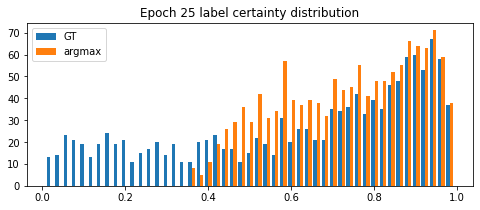

Epoch 26, F1 score = 0.564159846497833


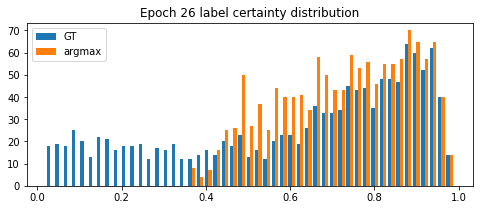

Epoch 27, F1 score = 0.5847384765139871


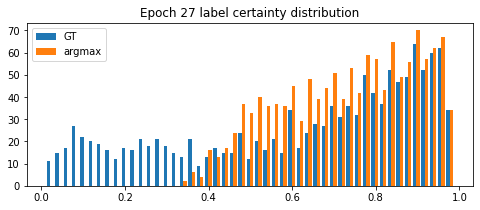

Epoch 28, F1 score = 0.5607792573975653


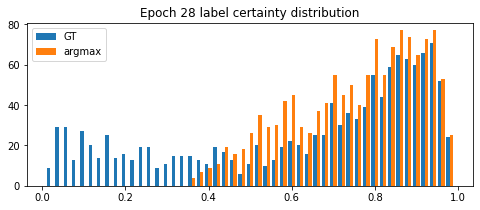

Epoch 29, F1 score = 0.5901732311218582


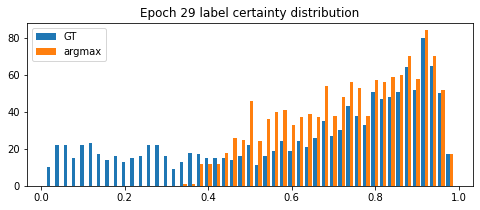

In [7]:
# we are setting up the validation set as the calibration set, to be more kosher, you should use an unseen subset of training
# check the certainty distribution of validation set
def certainty_hist(y, preds, epoch=-1):
    # y is (N,) integer array of C classes
    # preds is (N, C) array
    pred_classes = np.argmax(preds,axis=1)
    pred_confidence = np.max(preds,axis=1)
    gt_confidence = preds[range(len(y)),y]
    print(f"Epoch {epoch}, F1 score = {f1_score(y, pred_classes, average='macro')}")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.hist([gt_confidence, pred_confidence], bins=49)
    plt.legend(['GT', 'argmax'])
    plt.title(f"Epoch {i} label certainty distribution")
    plt.show()

# first check the validation set for naive softmaxing
for i in range(len(val_df)):
    y = val_df[i]['y']
    preds = softmax(val_probs[i], axis=1)
    certainty_hist(y, preds, i)

In [8]:
# run conformal prediction on a select epoch to return the prediction sets
def RAPS(y, preds, desired_accuracy=0.9):
    # y is (N,) integer array of C classes
    # preds is (N, C) array of confidences
    # desired_accuracy is equivalent to 1-alpha in CP literature
    N = len(y)
    pred_classes = np.argmax(preds,axis=1)
    pred_confidence = np.max(preds,axis=1)
    gt_confidence = preds[range(N),y]
    # calculate the conformal score s as a general imprecise uncertainty measure (can be many ways, this is a simple way)
    s = 1 - gt_confidence
    # find the q level
    q_level = np.quantile(s, desired_accuracy)
    adj_q_level = np.ceil((N+1) * desired_accuracy)/N
    # create sets based on the q-level
    cutoff = 1 - adj_q_level
    conformal_set = []
    for i in range(N):
        conformal_set.append(preds[i] >= cutoff)
    return np.array(conformal_set)

y = val_df[2]['y']
preds = softmax(val_probs[2], axis=1)
cs = RAPS(y, preds, ALPHA)

In [9]:
# test the coverage of conformal prediction
def coverage_test(y, preds_cover):
    # y is (N,) integer array of C classes
    # preds_cover is (N, C) boolean array indicating the cover
    correct = []
    for i in range(len(y)):
        if preds_cover[i, y[i]]:
            correct.append(True)
        else:
            correct.append(False)
    return np.array(correct)

correctness = coverage_test(y, cs) 
print(np.sum(correctness)/len(y)) # should be around 0.9

0.9267175572519084


In [10]:
def class_conditional_coverage_test(y, preds_cover, num_classes=4):
    # returns an accuracy for each class
    class_cond_acc = np.zeros(num_classes)
    for c in range(num_classes):
        mask = y == c
        preds_c = preds_cover[mask]
        N_c = len(preds_c)
        correct = 0
        for i in range(N_c):
            if preds_c[i,c]:
                correct += 1
        class_cond_acc[c] = correct/N_c
    return class_cond_acc
correctness = class_conditional_coverage_test(y, cs, N_CLASSES) 
correctness

array([0.82517483, 0.77005348, 0.99641577])

In [11]:
# check the cardinality of the conformal prediction
def cp_cardinality(y, preds_cover, preds, n_classes=4):
    cardinality = np.sum(preds_cover, axis=1)
    correct = coverage_test(y, preds_cover)
    card_correct = cardinality[correct]
    card_incorrect = cardinality[~correct]
    
    n_bins = n_classes + 1
    c_amount, c_bins = np.histogram(card_correct, bins=np.arange(n_bins)+0.5)
    n_amount, _ = np.histogram(card_incorrect, bins=np.arange(n_bins)+0.5)
    card_acc = c_amount / (c_amount + n_amount + 1e-9)
    print(f"Number of correct preds of size [1..N_classes]: {c_amount}")
    print(f"Number of incorrect preds of size [1..N_classes]: {n_amount}")
    print(f"Accuracy of preds of size [1..N_classes]: {card_acc}")

    top1_accs = []
    pred_classes = np.argmax(preds, axis=1)
    for i in np.arange(n_classes)+1:
        gt_w_card_i = y[cardinality==i]
        pred_w_card_i = pred_classes[cardinality==i]
        acc_w_card_i = np.sum(gt_w_card_i == pred_w_card_i) / (len(gt_w_card_i) + 1e-9)
        top1_accs.append(acc_w_card_i)
    print(f"Top-1 acc of preds of size [1..N_classes]: {top1_accs}")
    return np.mean(cardinality)

cp_cardinality(y, cs, preds, n_classes=N_CLASSES)

Number of correct preds of size [1..N_classes]: [320 482 412]
Number of incorrect preds of size [1..N_classes]: [43 53  0]
Accuracy of preds of size [1..N_classes]: [0.8815427  0.90093458 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.8815426997220894, 0.7009345794379422, 0.4975728155327729]


2.0374045801526717

In [12]:
# run conformal prediction on each epoch
f1s = []
coverages = []
cardinalities = []
for i in range(len(val_df)):
    y = np.array(val_df[i]['y'])
    preds = softmax(val_probs[i], axis=1)
    pred_classes = np.argmax(preds,axis=1)
    print(f"Epoch {i}")
    print(f"Original classifier F1 = {f1_score(y, pred_classes, average='macro')}")
    f1s.append(f1_score(y, pred_classes, average='macro'))
    cs = RAPS(y, preds, ALPHA)
    correctness = coverage_test(y, cs)
    print(f"Conformal coverage accuracy = {np.sum(correctness)/len(y)}")
    coverages.append(np.sum(correctness)/len(y))
    correctness = class_conditional_coverage_test(y, cs, num_classes=N_CLASSES)
    print(f"Class-conditional coverage accuracy = {correctness}")
    avg_card = cp_cardinality(y, cs, preds, n_classes=N_CLASSES)
    cardinalities.append(avg_card)

Epoch 0
Original classifier F1 = 0.4212620277688847
Conformal coverage accuracy = 0.8740458015267175
Class-conditional coverage accuracy = [0.66083916 0.63636364 1.        ]
Number of correct preds of size [1..N_classes]: [466 482 197]
Number of incorrect preds of size [1..N_classes]: [89 76  0]
Accuracy of preds of size [1..N_classes]: [0.83963964 0.86379928 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.8396396396381268, 0.6093189964146787, 0.41116751268826823]
Epoch 1
Original classifier F1 = 0.5342491693827639
Conformal coverage accuracy = 0.9465648854961832
Class-conditional coverage accuracy = [0.8951049  0.80748663 0.99522103]
Number of correct preds of size [1..N_classes]: [308 456 476]
Number of incorrect preds of size [1..N_classes]: [30 40  0]
Accuracy of preds of size [1..N_classes]: [0.9112426  0.91935484 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.9112426035475999, 0.7318548387082019, 0.5126050420157299]
Epoch 2
Original classifier F1 = 0.51096009

Conformal coverage accuracy = 0.9435114503816794
Class-conditional coverage accuracy = [0.90909091 0.7486631  0.99880526]
Number of correct preds of size [1..N_classes]: [360 522 354]
Number of incorrect preds of size [1..N_classes]: [40 34  0]
Accuracy of preds of size [1..N_classes]: [0.9        0.93884892 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.89999999999775, 0.7589928057540306, 0.5056497175126959]
Epoch 22
Original classifier F1 = 0.5565322484090599
Conformal coverage accuracy = 0.9381679389312977
Class-conditional coverage accuracy = [0.83566434 0.81818182 1.        ]
Number of correct preds of size [1..N_classes]: [369 518 342]
Number of incorrect preds of size [1..N_classes]: [34 47  0]
Accuracy of preds of size [1..N_classes]: [0.91563275 0.91681416 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.9156327543401598, 0.7115044247775018, 0.48830409356582366]
Epoch 23
Original classifier F1 = 0.5743524313961071
Conformal coverage accuracy = 0.94045801526

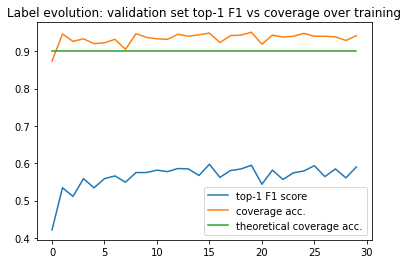

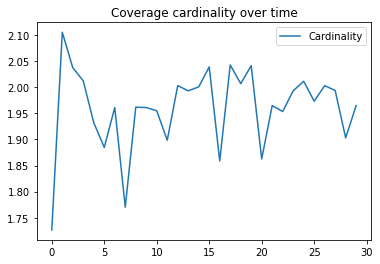

In [13]:
plt.plot(range(len(val_df)), f1s)
plt.plot(range(len(val_df)), coverages)
plt.plot(range(len(val_df)), np.full(shape=len(val_df), fill_value=ALPHA))
plt.title('Label evolution: validation set top-1 F1 vs coverage over training')
plt.legend(['top-1 F1 score', 'coverage acc.', 'theoretical coverage acc.'])
plt.show()

plt.figure()
plt.plot(range(len(val_df)), cardinalities)
plt.title('Coverage cardinality over time')
plt.legend(['Cardinality'])
plt.show()